# Sieci neuronowe - pierwszy stopień wtajemniczenia
Autor: Anna Dawid

Korekta: Rafał Masełek

Dzisiaj pod lupę weźmiemy jeden z najpopularniejszych i wszechstronnych modeli uczenia maszynowego - sieci neuronowe. Skupimy się na dwóch zagadnieniach: jak znaleźć optymalną architekturę sieci oraz o arcyważnym problemie regularyzacji. Będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Import danych MNIST

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Dzisiaj usuniemy przypadkowość z ćwiczenia, żeby mieć pewność, że zobaczymy to, co planuję ;)
seed = 128
rng = np.random.RandomState(seed)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

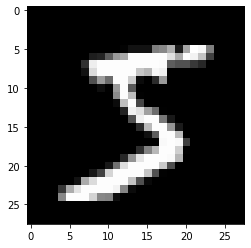

In [2]:
from tensorflow.keras.datasets import mnist
 
# MNIST współpracuje z keras, zbudowany jest z predefiniowanych 60 000 danych treningowych i 10 000 danych testowych
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from matplotlib import pyplot as plt
print(X_train[0])
plt.imshow(X_train[0], cmap='gray')

Dzisiaj korzystamy z głębokich sieci neuronowych, ale one wciąż nie są przystosowane do analizy obrazków (w przeciwieństwie do sieci, których będziemy używać na kolejnych zajęciach). Na wejściu potrzebują więc jednowymiarowy ciąg danych. Musimy też nasze dane znormalizować.

In [3]:
# Reshape'ujemy
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train[0])
print(X_train[0].shape)

# Przygotowujemy inty do dzielenia
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Wyjątkowy sposób normalizacji, bo wiemy, że piksele czarno-białe zawierają się w zakresie od 0 do 255
X_train /= 255
X_test /= 255

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [4]:
from tensorflow.keras.utils import to_categorical

# Musimy jeszcze popracować z etykietkami. Mamy wskazanie, który obrazek przedstawia którą liczbę,
# ale sieć potrzebuje szczególnego sformatowania
print("Oryginalny sposób zapisu: ", y_train[0])
print(y_train.shape)

# dokumentacja kodowania
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
print("Po zmianie: ", Y_train[0])
print(Y_train.shape)

Oryginalny sposób zapisu:  5
(60000,)
Po zmianie:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(60000, 10)


## Stworzenie pierwszej architektury sieci neuronowej

Pierwsza najważniejsza informacja z dzisiejszych zajęć: **nie ma uniwersalnych i uznanych szczegółowych zasad jak budować optymalną sieć neuronową dla danego problemu**. Głównymi narzędziami programistów są "metoda prób i błędów" oraz stworzona przed doświadczenie intuicja. Wielu matematyków i informatyków głowi się nad bardziej ścisłym sformułowaniu tego zagadnienia, są już pewne poszlaki, dla zainteresowanych polecam [tę publikację](https://arxiv.org/abs/1712.04741).

Także i my jesteśmy skazani na metodę prób i błędów. Naszym pierwszym wyznacznikiem będzie skuteczność samego treningu. Będziemy obserwować jak zmienia się funkcja błędu i dokładność (accuracy). Nie musimy szukać lepszej miary jakości, jako że mamy zbalansowany zestaw danych.

Drugim wyznacznikiem będzie skuteczność modelu na zestawie testowym (lub walidacyjnym, jak zobaczymy na końcu ćwiczenia).

In [5]:
# tworzymy model, korzystami z API sekwencyjnego, w którym kolejne warstwy ułożone są w ciąg/łańcuszek
# jest to bardzo prosta i wygodna metoda tworzenia sieci feed-forward
def create_model():
    # tworzymy obiekt typu Sequential
    model = Sequential()
    # dodajemy warstwę wejściową
    model.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
    # dodajemy kolejne warstwy po 500 neuronów każda
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    # dodajemy ostatnią warstwę z 10 neuronami (liczba klas) i funkcją aktyw. 'softmax'
    model.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas
    # zwracamy model
    return model

In [6]:
# Importujemy biblioteki do zbudowania sieci
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

# jedna epoka to jeden trening sieci
epochs = 10
# rozmiar partii danych, której używamy trenując sieć
batch_size = 128
model = create_model()

# wypiszmy informacje o sieciach
model.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________


## Pierwszy trening

Zastosujemy algorytm optymalizacyjny Adam (ze względu na jego dużą szybkość, choć w ogólności ma swoje problemy i warto pamiętać o istnieniu SGD + momentum). Będziemy obserwować dokładność i funkcję błędu modelu zarówno na danych treningowych, jak i testowych.

In [7]:
# kompilujemy model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitujemy model do danych, zapisujemy zwracany obiekt do zmiennej
trained_model_noreg = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2183 - accuracy: 0.9334 - val_loss: 0.1041 - val_accuracy: 0.9659
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0877 - accuracy: 0.9731 - val_loss: 0.0977 - val_accuracy: 0.9704
Epoch 3/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.1090 - val_accuracy: 0.9680
Epoch 4/10
469/469 [==============================] - 6s 14ms/step - loss: 0.0490 - accuracy: 0.9846 - val_loss: 0.0833 - val_accuracy: 0.9760
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0372 - accuracy: 0.9883 - val_loss: 0.0778 - val_accuracy: 0.9772
Epoch 6/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0859 - val_accuracy: 0.9775
Epoch 7/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0299 - accuracy: 0.9913 - val_loss: 0.0767 - val_accuracy: 0.979

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


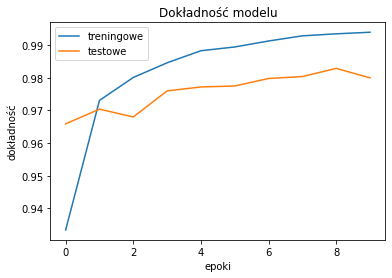

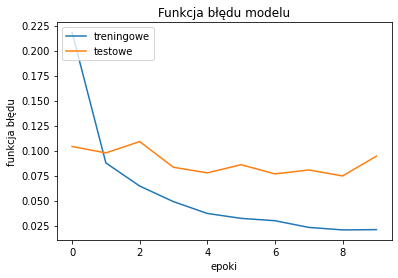

In [8]:
# Sprawdźmy jakie dane o treningu są zapisane dla naszego treningu 'trained_model_5d'
print(trained_model_noreg.history.keys())

model_history = trained_model_noreg
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

Co widzicie?

**Odp: ??**

## Metody regularyzacji

Coś co powinno Wam dawać do myślenia to to, że jest dowód matematyczny na to, że sieć neuronowa z jedną warstwą jest w stanie dowolnie dokładnie aproksymować dowolną funkcję matematyczną. A my stosujemy nie jedną, a kilka warstw! W pierwszym przybliżeniu to dla Was sygnał, że sieci neuronowe są świetne do opisywania dowolnie skomplikowanych problemów, także tych nie istniejących :P mam na myśli, że jak dacie sieci wystarczająco dużo parametrów i czasu do treningu, to będzie w stanie wyciągnąć 100% dokładności na danych treningowych. Gwarantuję Wam jednak, że konsekwencją będzie też kiepska generalizacja, czyli dokładność na danych niewidzianych podczas treningu będzie znacząco mniejsza.

Serce uczenia maszynowego nie leży w fitowaniu modelu do danych. Leży w dobrej generalizacji tego modelu na dane niewidoczne podczas treningu.

Gdy widzimy, że model świetnie działa na danych treningowych, a źle generalizuje (tzw. overfitting), to możemy dokonać zmian:
- w modelu
- w danych

Drugi sposób pokażę Wam za tydzień, dziś się skupimy na pierwszym podejściu. Zawsze można próbować uprościć architekturę, tak aby dokładność modelu na danych treningowych utrzymała się na podobnym poziomie, a wzrosła na testowych. Ponadto, na pomoc przychodzą nam metody regularyzacji, które zmieniają nam nieco model, upraszczają go i zwiększają zdolność generalizacji.

### Wczesne zatrzymywanie (Early Stopping)

To metoda ograniczająca czas treningu - zostaje on przerwany po wystąpieniu n epok z rzędu (n = patience), podczas których funkcja błędu walidacyjna się nie zmienia.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2184 - accuracy: 0.9334 - val_los

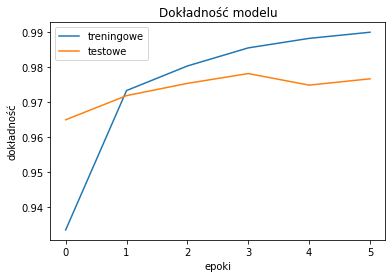

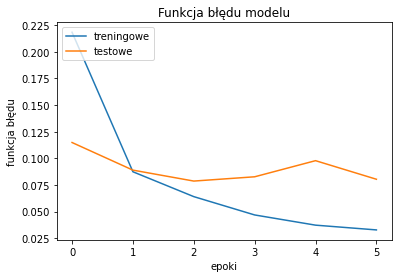

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

model_stop = create_model()
model_stop.summary(line_length=None, positions=None, print_fn=None)

model_stop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# zwróc uwagę na parametr 'callbacks'
trained_model_stop = model_stop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                    callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

model_history = trained_model_stop

# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

### Regularyzacja L2 i L1

To dołożenie do funkcji błędu czynników, które rosną wraz z wielkością wag w modelu - karzą model za wagi o dużych wartościach. Bazuje na założeniu, że prostsze modele mają mniejsze wagi.

L1 jest "mocniejsza", czasem aż zeruje wagi, więc jest przydatna w poszukiwaniach optymalnej architektury, gdy szukamy, które neurony wyrzucić, do mniejszej modyfikacji sieci używana jest L2.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 11s 24ms/step - loss: 1.0419 - accuracy: 0.9280 - val_lo

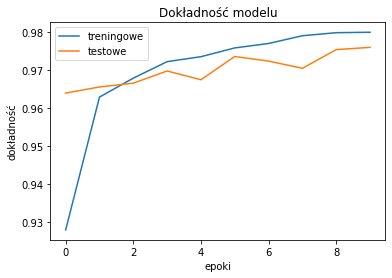

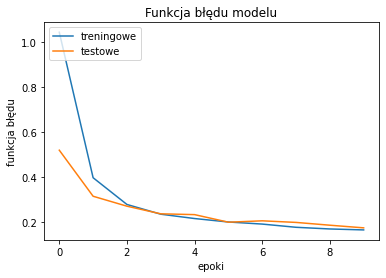

In [10]:
from tensorflow.keras import regularizers

l2_lambda = 0.001

model_l2 = Sequential()
model_l2.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
# zwróc uwagę na regularyzację
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas
model_l2.summary(line_length=None, positions=None, print_fn=None)

model_l2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_l2 = model_l2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

model_history = trained_model_l2
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

### Dropout

Bardzo ciekawe podejście, polegające na losowym zerowaniu % neuronów podczas treningu. To uczy sieć, by nie "polegała" za bardzo na żadnym pojedynczym neuronie.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 500)              

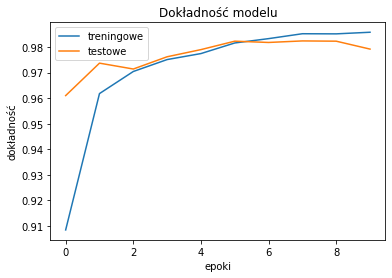

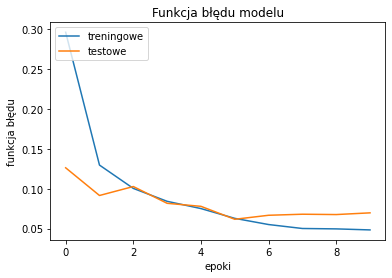

In [11]:
from tensorflow.keras.layers import Dropout

dropout_rate = 0.25

model_drop = Sequential()
model_drop.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
model_drop.add(Dense(500, activation='relu'))
# dropout można zaimplementować jako warstwę
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model_drop.summary(line_length=None, positions=None, print_fn=None)

model_drop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_drop = model_drop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

model_history = trained_model_drop
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Zadanie na dzisiaj

Metody te można łączyć. W szczególności można myśleć o Early Stopping jako metodzie podpowiadającej jak długo trenować sieć (ile epok), L1 może pomóc przy tworzeniu architektury, L2 lub Dropout stosujemy przy finalnym treningu.

Czujny uczestnik zauważy, że to co tutaj robimy to fitowanie hiperparametrów do danych, tym razem już nie treningowych, ale testowych. A zawsze podkreślaliśmy, że trening (dobieranie parametrów modelu) powinien być oddzielony od ostatecznych danych sprawdzających jakość modelu. Jako że doszedł nam dodatkowy rozbudowany etap - dobieranie hiperparametrów modelu (takich jak liczba epok, częstość Dropoutu, czy siła regularyzacji L1 czy L2), to potrzebujemy dodatkowego zestawu danych. Nazywa się on zestawem "walidacyjnym".

Ostatecznie więc profesjonaliści dzielą cały dostępny zestaw danych na: 

- dane treningowe, do których fitują model, obserwując jednocześnie dokładność na zestawie walidacyjnym
- dane walidacyjne, do których dobiera się hiperparametry
- dane testowe, służące już wyłącznie do sprawdzenia jakości finalnego modelu

Zadanie na dziś to:
1) stwórz sieć z użyciem jednego lub kilku rodzajów regularyzacji

2) skompiluj i dopasuj model do danych, użyj 30% zbioru treningowego do walidacji ( dokumentacja metody fit() )

3) znajdź optymalne parametry sieci i regularyzacji

4) sprawdź działanie sieci na danych testowych

5) sporządź raport z klasyfikacji z wykresami

Powodzenia! :)